In [2]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0xffffffff
cpu MHz		: 2199.998
cache size	: 56320 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa mmio_stale_data retbleed
bogomips	: 4399.99
clflush size	: 64
cache_alignment	: 64
addres

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install

In [ ]:
import pandas as pd
import numpy as np
import re
from konlpy.tag import Okt
from typing import List
import fasttext
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from collections import defaultdict

In [ ]:
class TextSet:
  DF_PATH = '/content/drive/MyDrive/언어순화 모델 프로젝트/Data/political.csv'
  STOP_WORD_PATH = '/content/drive/MyDrive/언어순화 모델 프로젝트/Data/stop_word.txt'
  BAD_WORD_PATH = "/content/drive/MyDrive/언어순화 모델 프로젝트/Data/bad_word.txt"

  # 크롤링 데이터 로드
  def load_data(self):
    return pd.read_csv(TextSet.DF_PATH,usecols=['text','label'])

  # 불용어 사전 로드
  def load_stop_word(self):
    with open(TextSet.STOP_WORD_PATH, "r") as f:
      return {w.strip() for w in f.readlines()}

  # 비속어 사전 로드
  def load_bad_word(self):
    with open(TextSet.BAD_WORD_PATH,'r',encoding="utf-8") as f:
      return {st.strip() for st in f.readlines()}


class FastTextModel:

  # 초성 리스트
  CHOSEONG_LIST = [char for char in "ㄱㄲㄴㄷㄸㄹㅁㅂㅃㅅㅆㅇㅈㅉㅊㅋㅌㅍㅎ"]
  # 중성 리스트
  JUNGSEONG_LIST  = [chr(char) for char in range(ord('ㅏ'),ord('ㅣ')+1)]
  # 종성 리스트
  JONGSEONG_LIST = [char for char in "-ㄱㄲㄳㄴㄵㄶㄷㄹㄺㄻㄼㄽㄾㄿㅀㅁㅂㅄㅅㅆㅇㅈㅊㅋㅌㅍㅎ"]

  # 토큰화된 텍스트 셋
  SAVE_TEXT_PATH = '/content/drive/MyDrive/언어순화 모델 프로젝트/강재전 작업/tokenized_data.txt'
  # 모델 저장 ㅌㅌ'ㅌ
  SAVE_MODEL_PATH = '/content/drive/MyDrive/언어순화 모델 프로젝트/강재전 작업/fasttext_model.bin'

  def __init__(self):
    # 크롤링 데이터
    self.text_set = TextSet().load_data()
    self.okt = Okt()
    self.model = None

  # 일괄 전처리 함수
  def preprocessing(self):
    # 한글·공백을 제외한 문자 제거
    self.text_set['text'] = self.text_set['text'].apply(self.remove_other_letter)
    # 형태소 분리 및 불용어 제거
    self.text_set['text'] = self.text_set['text'].apply(self.tokenize_remove_stop_word)
    # 초성·중성·종성으로 분리
    self.text_set['text']= self.text_set['text'].apply(self.separate_list)

    # 단어가 4개 이상 24개 이하만 추출(생략)
    # self.text_set = self.text_set[self.text_set['text'].apply(lambda x : 4<=len(x)<=24)]

  # 한글·공백을 제외한 문자 제거 함수
  def remove_other_letter(self,word):
    pattern = re.compile('[^ㄱ-ㅎ가-힣 ]')
    return re.sub(pattern,'',word)

  # 형태소 분리 및 불용어 제거 함수
  def tokenize_remove_stop_word(self,word):
    word_list = self.okt.morphs(word)
    result_list = list()
    for w in word_list:
      if w not in TextSet().load_stop_word():
        result_list.append(w)
    return result_list

  # 초성·중성·종성으로 분리(리스트)
  def separate_list(self,word_list:List):
    result_list = list()
    for word in word_list:
      result_list.append(self.separate(word))
    return result_list

  # 초성·중성·종성으로 분리(단어)
  ## 예 : 병신새끼야 -> ㅂㅕㅇㅅㅣㄴㅅㅐ-ㄲㅣ-ㅇㅑ-
  def separate(self,korean_word:str):
    result_list = list()
    for word in korean_word:
      for w in word:
        if ord(w) <=12643:
          result_list.append(w+'--')
        else:
          ## 588개 마다 초성이 바뀜.
          ch1 = (ord(w) - ord('가'))//588
          ## 중성은 총 28가지 종류
          ch2 = ((ord(w) - ord('가')) - (588*ch1)) // 28
          ch3 = (ord(w) - ord('가')) - (588*ch1) - 28*ch2
          result_list.append(self.CHOSEONG_LIST[ch1] + self.JUNGSEONG_LIST[ch2] + self.JONGSEONG_LIST[ch3])
    return ''.join(result_list)


  # 초성 중성 종성 분리 복구 함수
  ## 예 : ㅂㅕㅇㅅㅣㄴㅅㅐ-ㄲㅣ-ㅇㅑ- > 병신새끼야
  def separate_reversed(self,korean_word):
    # 정규화를 통해 - (빈값) 대체
    korean_word = [re.sub('-','',korean_word[i:i+3]) for i in range(0,len(korean_word), 3)]
    result_list = list()
    for word in korean_word:
      result = ord('가')
      if len(word) == 3:
        result += (self.CHOSEONG_LIST.index(word[0]) * 21 * 28) + (self.JUNGSEONG_LIST.index(word[1]) * 28) + self.JONGSEONG_LIST.index((word[2]))
        result_list.append(chr(result))
      elif len(word) == 2:
        result += (self.CHOSEONG_LIST.index(word[0]) * 21 * 28) + (self.JUNGSEONG_LIST.index(word[1]) * 28)
        result_list.append(chr(result))
      else:
        result_list.append(word)

    return ''.join(result_list)

  # 토큰화 된 텍스트 데이터셋(DataFrame) 저장 함수
  def save_text_set(self):
    with open(FastTextModel.SAVE_TEXT_PATH, 'w') as out:
        for line in self.text_set['text']:
          out.write(' '.join(line) + '\n')

  # 학습된 FastText 모델 저장 함수
  def save_model(self):
    self.model.save_model(FastTextModel.SAVE_MODEL_PATH)

  # 학습된 FastText 모델 로드 함수
  def load_model(self):
    self.model = fasttext.load_model(FastTextModel.SAVE_MODEL_PATH)

  # FastText모델 학습 함수
  def run(self):
    self.model = fasttext.train_unsupervised('/content/drive/MyDrive/언어순화 모델 프로젝트/강재전 작업/tokenized_data.txt'
                                             ,model = 'skipgram'
                                             ,lr = 0.05
                                             ,dim = 100
                                             ,ws = 3
                                             ,epoch = 50
                                             ,minn = 1
                                             ,word_ngrams = 5)

  # LSTM 모델 학습을 위한 벡터 데이터셋 생성 함수
  def get_train_data(self):
    train_vec = list()
    for words in self.text_set['text']:
      word_list_vec = list()
      # 형태소 분리된 리스트 길이와 최대 Dimension(24)와 비교. 남은 벡터는 3차원 0값으로 구성
      for i in range(24):
        if i < len(words):
          word_list_vec.append(self.model[words[i]])
        else:
          word_list_vec.append(np.array([0]*100))
      word_list_vec = np.array(word_list_vec)
      train_vec.append(word_list_vec)
    return np.array(train_vec)



class LstmModel:
    def __init__(self):
        self.model = self.build_model()
    def build_model(self):
        model = Sequential()
        model.add(LSTM(64, input_shape=(24, 100), return_sequences=True))
        model.add(LSTM(32))
        model.add(Dense(16, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])
        return model

    # LSTM 모델 학습 함수
    def fit(self, X_train, y_train, epochs=10, batch_size=32, validation_data = (X_test, y_test)):
        history = self.model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data = validation_data)
        return history

    def predict(self, X_test):
        predictions = self.model.predict(X_test)
        return predictions

    def evaluate(self, X_test, y_test):
        loss, accuracy = self.model.evaluate(X_test, y_test)
        return loss, accuracy

In [ ]:
"""
fasttext 모델 생성을 위한 처리 로직(처음에만 구동)
"""

fasttext_model = FastTextModel()
fasttext_model.preprocessing()
fasttext_model.save_text_set()
fasttext_model.run()
fasttext_model.save_model()

In [ ]:
pd.read_csv('/content/drive/MyDrive/언어순화 모델 프로젝트/Data/political.csv',usecols=['text','label'])

,text,label
0,도태한남,1
1,한녀랑 엮이면 무조건 피해본다,1
2,새벽에 올라온 일본가서 똥싼 한녀 썰,1
3,국제사랑갤은 남성전용갤임,0
4,외녀들 왜케 착해보이냐 gif,1
...,...,...
11598,암드의 병크로 취소된 글카,1
11599,근데 솔직히 한남새끼들 일녀만난다고 쳐안나댔으면함,1
11600,준페이가 나서서 맞아주는 역 자처하니 만만하게 보는 새끼들이 많네,1
11601,신성 지금이라도 들어와라 늦지않앗다,1


In [ ]:
from sklearn.model_selection import train_test_split

X_train,X_test, y_train,y_test = train_test_split(fasttext_model.get_train_data(), fasttext_model.text_set['label'], test_size=0.2, random_state=0)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(8928, 24, 100) (2232, 24, 100) (8928,) (2232,)


In [ ]:
lstm_model = LstmModel()
history = lstm_model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/20
140/140 [==============================] - 22s 102ms/step - loss: 0.5795 - accuracy: 0.7021 - val_loss: 0.4818 - val_accuracy: 0.7621
Epoch 2/20
140/140 [==============================] - 8s 56ms/step - loss: 0.4975 - accuracy: 0.7728 - val_loss: 0.4721 - val_accuracy: 0.7841
Epoch 3/20
140/140 [==============================] - 6s 46ms/step - loss: 0.4666 - accuracy: 0.7920 - val_loss: 0.4493 - val_accuracy: 0.7908
Epoch 4/20
140/140 [==============================] - 8s 59ms/step - loss: 0.4311 - accuracy: 0.8094 - val_loss: 0.4277 - val_accuracy: 0.8109
Epoch 5/20
140/140 [==============================] - 6s 45ms/step - loss: 0.4104 - accuracy: 0.8243 - val_loss: 0.4249 - val_accuracy: 0.8105
Epoch 6/20
140/140 [==============================] - 8s 58ms/step - loss: 0.3751 - accuracy: 0.8392 - val_loss: 0.4214 - val_accuracy: 0.8150
Epoch 7/20
140/140 [==============================] - 7s 49ms/step - loss: 0.3619 - accuracy: 0.8455 - val_loss: 0.4264 - val_accuracy: 0.80

In [ ]:
lstm_model.model.save("/content/drive/MyDrive/언어순화 모델 프로젝트/강재전 작업/lstm_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#### 모델 테스트 수행

In [ ]:
from tensorflow import keras

In [ ]:
fasttext_model = FastTextModel()
fasttext_model.load_model()

lstm_model = LstmModel()
lstm_model.model = keras.models.load_model("/content/drive/MyDrive/언어순화 모델 프로젝트/강재전 작업/lstm_model.h5")

In [ ]:
# 문장 테스트용 함수
def test_sentence(s,fasttext:FastTextModel):
  # 1.한글·공백 이외 문자 제거 후, 형태소 분리 및 불용어 제거 수행
  test_word = fasttext.tokenize_remove_stop_word(fasttext.remove_other_letter(s))
  # 2.형태소 별 초성·중성·종성으로 분리
  test_word_split = fasttext.separate_list(test_word)
  # 3. 분리된 형태소를 3차원 ndarray 벡터로 변환
  test_word_vec = list()
  for i in range(24):
    if i < len(test_word_split):
      test_word_vec.append(fasttext.model[test_word_split[i]])
    else:
      test_word_vec.append(np.array([0]*100))
  test_word_vec = np.array(test_word_vec)
  test_word_vec = test_word_vec.reshape(1,test_word_vec.shape[0],test_word_vec.shape[1])

  # 4. LSTM 모델 예측 수행
  test_predict = lstm_model.model.predict([test_word_vec])
  print(f"lstm 모델 구동 결과 : 비속어가 포함되어 있을 확률 : {test_predict[0][0]}")
  find_slang(test_word_split,fasttext)

# 유사 비속어 개수 확인 함수
def find_slang(test_word_split,fasttext:FastTextModel):
  for word in test_word_split:
    result = fasttext.model.get_nearest_neighbors(word)
    similar_letter_dict = defaultdict(list)
    for _,temp in result:
      if not fasttext.remove_other_letter(temp):
        continue
      for w in TextSet().load_bad_word():
        if w in fasttext.separate_reversed(temp):
          similar_letter_dict[fasttext.separate_reversed(word)].append(w)
    for key,val in similar_letter_dict.items():
      print(f"{key} ==> 연관 비속어 : {val}")


In [ ]:
test_sentence('아 미드차이 존나 나네',fasttext_model)

1/1 [==============================] - 0s 67ms/step
lstm 모델 구동 결과 : 비속어가 포함되어 있을 확률 : 0.9999932050704956
존나 ==> 연관 비속어 : ['좆']


In [ ]:
def plot_training_history(history):
    # train_acc, val_acc
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
    # train_loss, val_loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

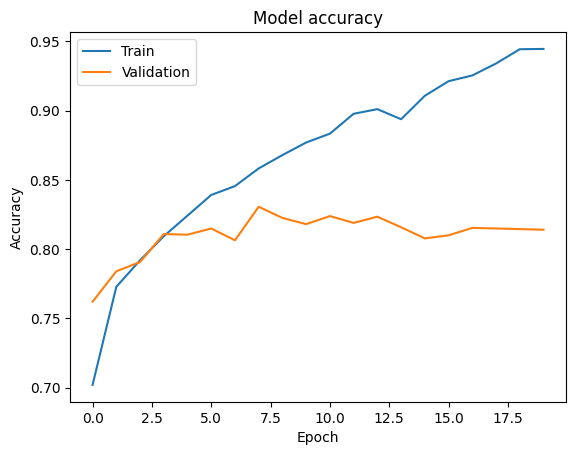

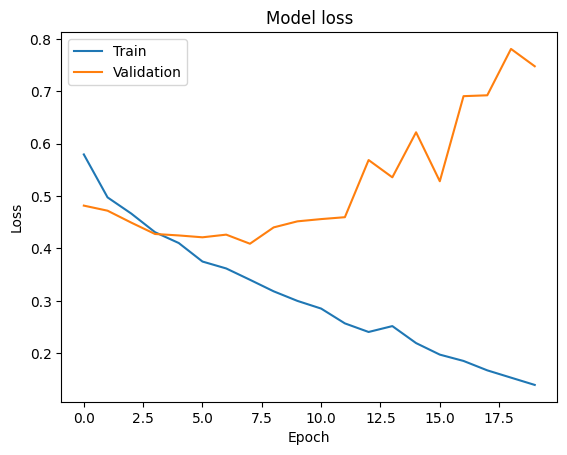

In [ ]:
plot_training_history(history)